In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    file_name = 'data1/' + file_name[41:]
    
    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Grouping all texts files
A dataframe is first created to keep individual files at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#list of the file names
files_list = os.listdir('data1')

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [12]:
# for verification purposes later, count the nr of characters for each content
sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
sources['file_len'].sum()

1779770

In [0]:
# variable containing all texts together
corpus = ''
for i in range(len(sources)):
  corpus += sources['file_content'][i]

In [14]:
# check length
len(corpus)

1779770


## 1.2 Removing stop words, punctuation, short words

In [15]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# remove punctuation and lower case (then depending on user input, leave the possibility to do one or the other)
tokens = nltk.word_tokenize(corpus)
#tokenized_corpus = [w.lower() for w in tokens if w.isalnum()]
# lower case, remove punctuation and only keep words that have more than 3 letters
tokenized_corpus = [w.lower() for w in tokens if (w.isalnum() and len(w) > 3 )]

In [0]:
# these lines are useful if we want to provide alternate stop words lists (NLTK)
# show list of default NLTK Italian stopwords
# stopwords.words('italian')
# ital_stopwords = stopwords.words('italian')
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
import spacy
from spacy.lang.it.stop_words import STOP_WORDS

In [0]:
spacy_it_sw = STOP_WORDS

In [0]:
tokenized_corpus_without_sw = [w for w in tokenized_corpus if not w in spacy_it_sw]

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
stemmed_corpus = [stemmer.stem(w) for w in tokenized_corpus_without_sw]

## 1.4 Lemmatize

In [0]:
# Lemmatize is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [26]:
!python -m spacy download it_core_news_sm

     |████████████████████████████████| 14.5MB 2.6MB/s 
  Created wheel for it-core-news-sm: filename=it_core_news_sm-2.2.5-cp36-none-any.whl size=14471130 sha256=5a489fc93d22d3dcad90fedffc5b83fda872bfb4e674224a21fa19327d308591
  Stored in directory: /tmp/pip-ephem-wheel-cache-ut948jal/wheels/a1/01/c2/127ab92cc5e3c7f36b5cd4bff28d1c29c313962a2ba913e720
Successfully built it-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')


In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# create dataframe with corpus, enables then to see easily original version compared to lemmatized version
corpus_df = pd.DataFrame(tokenized_corpus_without_sw, columns=['tokens'])
# to test only on 30 lines, use: corpus_df = pd.DataFrame(tokenized_corpus_without_sw[0:30], columns=['tokens'])

In [0]:
# add column with lemmatized version
corpus_df['lemmatized_token'] = corpus_df['tokens'].apply(lambda x: [token.lemma_ for token in it_nlp(x)] )

In [0]:
# uncomment to see sample output
# corpus_df[0:60]

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = corpus_df['lemmatized_token'].tolist()

# 2. Topics with LDA

In [31]:
# installation setup that works for Mallet: https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [32]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-05-12 08:17:12--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.9MB/s    in 1.2s    

2020-05-12 08:17:13 (12.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA

### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

### 2.1.2 TFIDF

In [0]:
# optional
# TFIDF for better performance
# https://en.wikipedia.org/wiki/Tf–idf / 
# https://rare-technologies.com/pivoted-document-length-normalisation/

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## 2.2 LDA

In [0]:
# set the number of topics here
numtopics = 5

### 2.2.1 LDA with Gensim and TFIDF

In [0]:
ldagensim = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=numtopics)

In [41]:
ldagensim.print_topics()

[(0,
  '0.038*"italiano" + 0.014*"venire" + 0.013*"importare" + 0.011*"cittadinanza" + 0.011*"inte" + 0.011*"polveriera" + 0.011*"qualo" + 0.007*"trovare" + 0.007*"quotidiano" + 0.007*"parigi"'),
 (1,
  '0.031*"processare" + 0.025*"italia" + 0.024*"grave" + 0.023*"roma" + 0.013*"prendere" + 0.013*"vivere" + 0.012*"donna" + 0.011*"cominciare" + 0.011*"standard" + 0.010*"bologna"'),
 (2,
  '0.016*"numerare" + 0.015*"mano" + 0.014*"rendere" + 0.013*"tentare" + 0.012*"raro" + 0.011*"calere" + 0.011*"illudere" + 0.010*"daily" + 0.010*"splendono" + 0.010*"vocile"'),
 (3,
  '0.015*"dispaccio" + 0.011*"fuoco" + 0.011*"conseguenza" + 0.011*"provato" + 0.010*"accusare" + 0.010*"gravissime" + 0.010*"irai" + 0.010*"penale" + 0.010*"umici" + 0.010*"naro"'),
 (4,
  '0.017*"telegrafico" + 0.013*"giornale" + 0.012*"potere" + 0.011*"imputazione" + 0.011*"spola" + 0.009*"nuovo" + 0.007*"dare" + 0.006*"popolare" + 0.006*"unito" + 0.006*"parlare"')]

### 2.2.2 LDA with Mallet, without TFIDF

In [42]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=numtopics, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [43]:
ldamallet.print_topics()

[(0,
  '0.021*"roma" + 0.015*"daily" + 0.011*"dire" + 0.009*"americano" + 0.008*"leggere" + 0.007*"altro" + 0.007*"states" + 0.007*"maggio" + 0.007*"mano" + 0.007*"operare"'),
 (1,
  '0.022*"dispaccio" + 0.015*"giornale" + 0.012*"italia" + 0.010*"mentire" + 0.010*"dovere" + 0.009*"quotidiano" + 0.009*"dare" + 0.009*"nome" + 0.009*"venire" + 0.007*"patrio"'),
 (2,
  '0.047*"italiano" + 0.011*"papa" + 0.008*"volere" + 0.008*"numerare" + 0.007*"parigi" + 0.007*"york" + 0.007*"gran" + 0.006*"telegrafico" + 0.006*"lottare" + 0.006*"parlare"'),
 (3,
  '0.015*"potere" + 0.013*"cardinale" + 0.011*"italia" + 0.008*"venire" + 0.008*"trovare" + 0.006*"popolare" + 0.006*"parere" + 0.006*"largest" + 0.006*"solo" + 0.006*"patrizio"'),
 (4,
  '0.012*"telegrafico" + 0.010*"nuovo" + 0.007*"presidente" + 0.007*"italian" + 0.007*"francese" + 0.006*"tenere" + 0.006*"perchè" + 0.006*"politico" + 0.006*"pubblicare" + 0.005*"zione"')]

### 2.2.3 LDA with Mallet with TFIDF

In [44]:
ldamallet_tfidf = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=numtopics, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [45]:
ldamallet_tfidf.print_topics()

[(0,
  '0.027*"italiano" + 0.019*"telegrafico" + 0.015*"daily" + 0.008*"leggere" + 0.007*"notizia" + 0.007*"states" + 0.007*"popolare" + 0.007*"francese" + 0.006*"tenere" + 0.006*"correre"'),
 (1,
  '0.023*"italia" + 0.021*"roma" + 0.010*"nuovo" + 0.009*"york" + 0.009*"quotidiano" + 0.007*"morto" + 0.007*"italian" + 0.007*"visitare" + 0.007*"altro" + 0.006*"unito"'),
 (2,
  '0.021*"dispaccio" + 0.020*"italiano" + 0.015*"giornale" + 0.010*"papa" + 0.010*"gran" + 0.009*"americano" + 0.009*"nome" + 0.009*"trovare" + 0.008*"volere" + 0.008*"parigi"'),
 (3,
  '0.017*"venire" + 0.013*"cardinale" + 0.011*"dire" + 0.010*"dovere" + 0.009*"dare" + 0.008*"numerare" + 0.008*"patrio" + 0.007*"presidente" + 0.007*"operare" + 0.007*"costare"'),
 (4,
  '0.017*"potere" + 0.009*"mentire" + 0.007*"grande" + 0.006*"maggio" + 0.006*"parere" + 0.006*"largest" + 0.006*"lottare" + 0.006*"patrizio" + 0.005*"chiesa" + 0.005*"ufficiale"')]

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

### 2.3.1 Coherence score LDA Gensim

In [48]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.8254564890386341


### 2.3.1 Coherence score LDA Mallet


In [49]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score LDA MAllet: ', coherence_ldamallet)


Coherence Score LDA MAllet:  0.8475200082743009


### 2.3.1 Coherence score LDA Mallet with TFIDF

In [50]:
# coherence score LDA with TFIDF (5 topics)
coherence_model_ldamallet_tfidf = CoherenceModel(model=ldamallet_tfidf, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet_tfidf = coherence_model_ldamallet_tfidf.get_coherence()
print('\nCoherence Score LDA Mallet TFIDF: ', coherence_ldamallet_tfidf)


Coherence Score LDA Mallet TFIDF:  0.8470329331622104


## 2.4 Coherence and number of topics

In [0]:
# Function to calculate optimal number of topics
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
# the cell below runs the function set just above and can take a long time to run (20-30 min)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=lemmatized_corpus, start=2, limit=40, step=1)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [58]:
# Store the value of the coherence scores for plotting later
topics_nr = []
topics_scores = []
limit=20; start=2; step=1;
x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    topics_nr.append(str(m))
    topics_scores.append(round(cv, 4))
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.8622
Num Topics = 3  has Coherence Value of 0.8566
Num Topics = 4  has Coherence Value of 0.8511
Num Topics = 5  has Coherence Value of 0.8472
Num Topics = 6  has Coherence Value of 0.8445
Num Topics = 7  has Coherence Value of 0.8415
Num Topics = 8  has Coherence Value of 0.8378
Num Topics = 9  has Coherence Value of 0.8353
Num Topics = 10  has Coherence Value of 0.8337
Num Topics = 11  has Coherence Value of 0.8317
Num Topics = 12  has Coherence Value of 0.83
Num Topics = 13  has Coherence Value of 0.8292
Num Topics = 14  has Coherence Value of 0.8265
Num Topics = 15  has Coherence Value of 0.8252
Num Topics = 16  has Coherence Value of 0.8236
Num Topics = 17  has Coherence Value of 0.8226
Num Topics = 18  has Coherence Value of 0.8207
Num Topics = 19  has Coherence Value of 0.8199


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

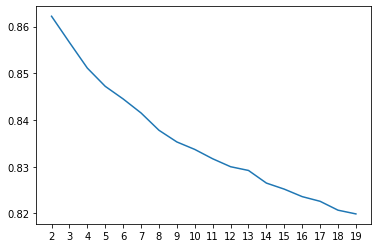

In [60]:
plt.plot(topics_nr, topics_scores)

In [0]:
# To analyse the results, the user can print the list of topics for different topic nr

In [61]:
# print topics for nr of topics = 2
numtopics = 2
gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=numtopics, id2word=id2word).print_topics()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.009*"italia" + 0.009*"italiano" + 0.007*"telegrafico" + 0.007*"venire" + 0.006*"giornale" + 0.005*"cardinale" + 0.004*"mentire" + 0.004*"nuovo" + 0.004*"dovere" + 0.003*"parigi"'),
 (1,
  '0.010*"italiano" + 0.009*"dispaccio" + 0.008*"roma" + 0.007*"potere" + 0.006*"daily" + 0.004*"dire" + 0.004*"gran" + 0.004*"york" + 0.004*"quotidiano" + 0.004*"dare"')]

In [63]:
# print topics for nr of topics = 3
numtopics = 3
gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=numtopics, id2word=id2word).print_topics()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.022*"italiano" + 0.014*"italia" + 0.011*"telegrafico" + 0.008*"cardinale" + 0.006*"dovere" + 0.006*"gran" + 0.005*"parigi" + 0.005*"leggere" + 0.004*"grande" + 0.004*"notizia"'),
 (1,
  '0.013*"dispaccio" + 0.013*"roma" + 0.010*"venire" + 0.009*"giornale" + 0.006*"dire" + 0.006*"nuovo" + 0.005*"trovare" + 0.005*"numerare" + 0.004*"patrio" + 0.004*"italian"'),
 (2,
  '0.010*"potere" + 0.009*"daily" + 0.006*"mentire" + 0.006*"papa" + 0.006*"york" + 0.006*"italiano" + 0.006*"quotidiano" + 0.005*"nome" + 0.005*"volere" + 0.005*"americano"')]

In [64]:
# print topics for nr of topics = 4
numtopics = 4
gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=numtopics, id2word=id2word).print_topics()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.017*"roma" + 0.015*"telegrafico" + 0.012*"giornale" + 0.010*"venire" + 0.008*"dovere" + 0.007*"dare" + 0.007*"trovare" + 0.006*"morto" + 0.006*"notizia" + 0.006*"maggio"'),
 (1,
  '0.022*"italiano" + 0.014*"potere" + 0.013*"italia" + 0.008*"papa" + 0.008*"nuovo" + 0.007*"quotidiano" + 0.007*"americano" + 0.007*"nome" + 0.006*"visitare" + 0.006*"costare"'),
 (2,
  '0.018*"dispaccio" + 0.011*"cardinale" + 0.007*"york" + 0.006*"leggere" + 0.006*"italia" + 0.006*"operare" + 0.006*"states" + 0.005*"francese" + 0.005*"popolare" + 0.005*"unito"'),
 (3,
  '0.015*"italiano" + 0.012*"daily" + 0.008*"dire" + 0.008*"mentire" + 0.006*"numerare" + 0.006*"parigi" + 0.006*"grande" + 0.006*"altro" + 0.006*"gran" + 0.005*"parere"')]